# Complementaria 6: Algoritmos de Caminos Mínimos


## Importar librerías


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Importar datos


In [2]:
# Cargar datos desde un archivo .xlsx usando pandas, 'Plantilla.xlsx' sera nuestro archivo
df_r = pd.read_excel("Plantilla.xlsx", sheet_name="UltraCargo_Rutas_Transporte")
df_c = pd.read_excel("Plantilla.xlsx", sheet_name="UltraCargo_Centros_Logísticos")

In [3]:
# Dimension de los dataframes
print("Dimensión de df_r:", df_r.shape)
print("Dimensión de df_c:", df_c.shape)

Dimensión de df_r: (144, 11)
Dimensión de df_c: (20, 4)


In [4]:
# Validar que los datos de la hoja 'UltraCargo_Rutas_Transporte' se hayan cargado correctamente
df_r.head()

,Origen,Destino,Distancia,Velocidad,Frontera,Alta_Demanda,Capacidad,Horario,Terrestre,Aereo,Vuelos
0,San Diego,Phoenix,500,100,0,1,30,19,1,0,0
1,San Diego,Las Vegas,1860,80,1,1,11,12,0,1,2
2,San Diego,Dallas,2274,100,1,1,35,23,1,0,0
3,San Diego,Austin,909,100,1,0,35,24,1,0,0
4,San Diego,San Antonio,614,80,1,0,47,23,0,1,2


In [5]:
# Validar que los datos de la hoja 'UltraCargo_Centros_Logísticos' se hayan cargado correctamente
df_c.head()

,Codigo,Ciudad,Estado,País
0,1,San Diego,California,EE.UU.
1,2,Los Angeles,California,EE.UU.
2,3,Phoenix,Arizona,EE.UU.
3,4,Las Vegas,Nevada,EE.UU.
4,5,Denver,Colorado,EE.UU.


## Crear el grafo dirigido para todas las rutas disponibles


In [6]:
def crear_grafo_dirigido(df_r):
    G = nx.DiGraph()  # Crear un grafo dirigido vacio

    # Agregar nodos al grafo desde el dataframe de centros logísticos
    for index, row in df_r.iterrows():
        costo = (
            (15 * row["Distancia"])
            + (200 * row["Frontera"])
            + (150 * row["Alta_Demanda"])
        )
        G.add_edge(row["Origen"], row["Destino"], costo=costo)
    return G


# Crear el grafo dirigido
G = crear_grafo_dirigido(df_r)

## 1.1 Visualizar el grafo


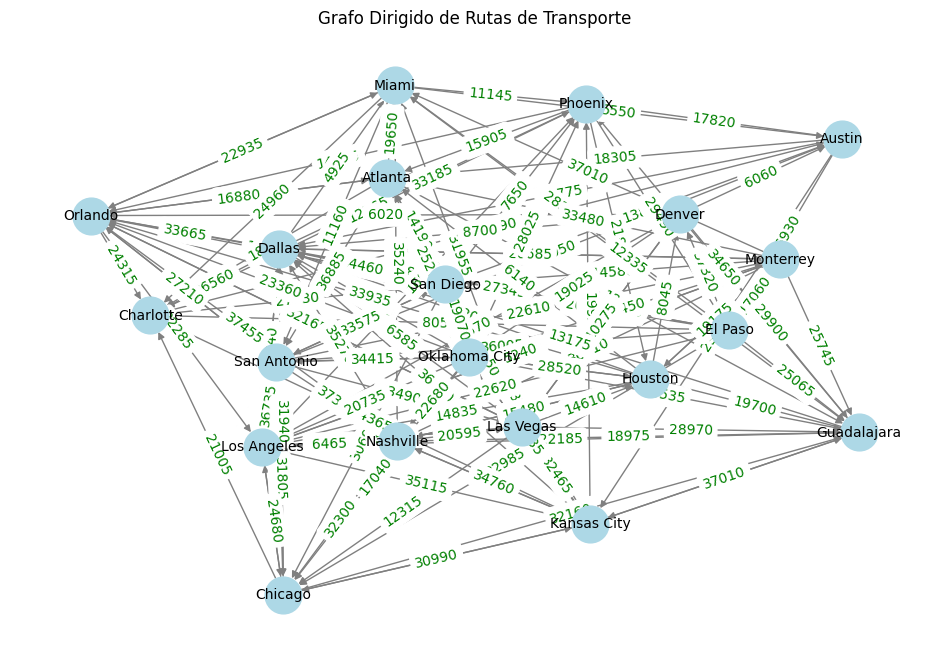

In [7]:
plt.figure(figsize=(12, 8), facecolor="white")
pos = nx.spring_layout(G)
nx.draw_networkx(
    G,
    pos,
    with_labels=True,
    node_color="lightblue",
    edge_color="gray",
    node_size=700,
    font_size=10,
)

# Mostrar los costos en las aristas
edge_labels = nx.get_edge_attributes(G, "costo")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="green")

plt.title("Grafo Dirigido de Rutas de Transporte")
plt.axis("off")
plt.show()

## 1.2 San Diego a Denver con 20 toneladas de mercancía, recargo de 15% si se excede la capacidad y restricción de rutas aéreas después de las 11 AM


In [8]:
# Parametros

carga = 20  # 20 toneladas de carga el cliente quiere enviar
hora_restriccion = 11  # Despues de las 11 am hay restriccion para vuelos aereos


# Hacer un nuevo grafo con los costos ajustados por la carga
def crear_grafo_dirigido_modificado(df_r, carga, hora_restriccion):
    G = nx.DiGraph()  # Crear un grafo dirigido vacio

    # Agregar nodos al grafo desde el dataframe de centros logísticos
    for index, row in df_r.iterrows():
        costo_base = (
            15 * row["Distancia"]
            + 200 * row["Frontera"]
            + (150 if row["Alta_Demanda"] == 1 else 0)
        )  # Incicializar costo base sin recargo
        recargo = 0  # Inicializar recargo en 0

        # Ajustar el costo según la carga
        if carga > row["Capacidad"]:  # Si la carga excede la capacidad de la ruta
            recargo = 0.15 * costo_base  # Recargo del 15%

        if (
            row["Aereo"] == 1 and row["Horario"] > hora_restriccion
        ):  # Si es ruta aerea y despues de la hora de restriccion
            continue  # No agregues esta arista

        costo_total = costo_base + recargo  # Costo total con recargo si aplica

        tiempo = (
            row["Distancia"] / row["Velocidad"]
        )  # Tiempo en horas = Distancia / Velocidad

        G.add_edge(
            row["Origen"],
            row["Destino"],
            costo=costo_total,
            distancia=row["Distancia"],
            tiempo=tiempo,
            frontera=row["Frontera"],
            tipo="Aerea" if row["Aereo"] == 1 else "Terrestre",
            capacidad=row["Capacidad"],
            horario=row["Horario"],
        )  # Agregar arista con atributos

    return G


# Crear el grafo dirigido modificado
G_mod = crear_grafo_dirigido_modificado(df_r, carga, hora_restriccion)

# Ruta de menor costo desde San Diego a Denver con costo como peso
rmc = nx.shortest_path(G_mod, source="San Diego", target="Denver", weight="costo")


# Calcular el costo total, distancia total y tiempo total de la ruta de menor costo monetario
def calcular_costos_ruta(G, ruta):
    costo_total = 0  # Inicializar costo total
    distancia_total = 0  # Inicializar distancia total
    tiempo_total = 0  # Inicializar tiempo total

    for i in range(
        len(ruta) - 1
    ):  # Iterar sobre cada tramo de la ruta excepto el ultimo (porque no tiene destino)
        origen = ruta[i]  # Nodo origen
        destino = ruta[i + 1]  # Nodo destino
        edge_data = G.get_edge_data(
            origen, destino
        )  # Obtener los datos de la arista, esto devuelve un diccionario con los atributos de la arista
        if edge_data is None:
            print(
                f"No hay arista entre {origen} y {destino} con las restricciones dadas."
            )
        costo_total += edge_data["costo"]  # Sumar el costo de la arista al costo total
        distancia_total += edge_data[
            "distancia"
        ]  # Sumar la distancia de la arista a la distancia total
        tiempo_total += edge_data[
            "tiempo"
        ]  # Sumar el tiempo de la arista al tiempo total

    return costo_total, distancia_total, tiempo_total


costo_total, distancia_total, tiempo_total = calcular_costos_ruta(G_mod, rmc)

print(
    f"Ruta de menor costo desde San Diego a Denver: {' -> '.join(rmc)}"
)  # Imprimir la ruta
print(
    f"Costo total de la ruta: ${costo_total:.2f}"
)  # Imprimir el costo total con 2 decimales
print(
    f"Distancia total de la ruta: {distancia_total:.2f} km"
)  # Imprimir la distancia total con 2 decimales
print(
    f"Tiempo total de la ruta: {tiempo_total:.2f} horas"
)  # Imprimir el tiempo total con 2 decimales

Ruta de menor costo desde San Diego a Denver: San Diego -> Atlanta -> Las Vegas -> Denver
Costo total de la ruta: $53748.25
Distancia total de la ruta: 3247.00 km
Tiempo total de la ruta: 47.88 horas


## 1.3 Guadalajara a Miami en un tiempo minimo de 70 horas, con solo rutas aereas en el estado de Texas y nueva formula de costo


### 1.3.1 Crear el grafo modificado con las restriciones aereas en Texas y nueva formula de costo


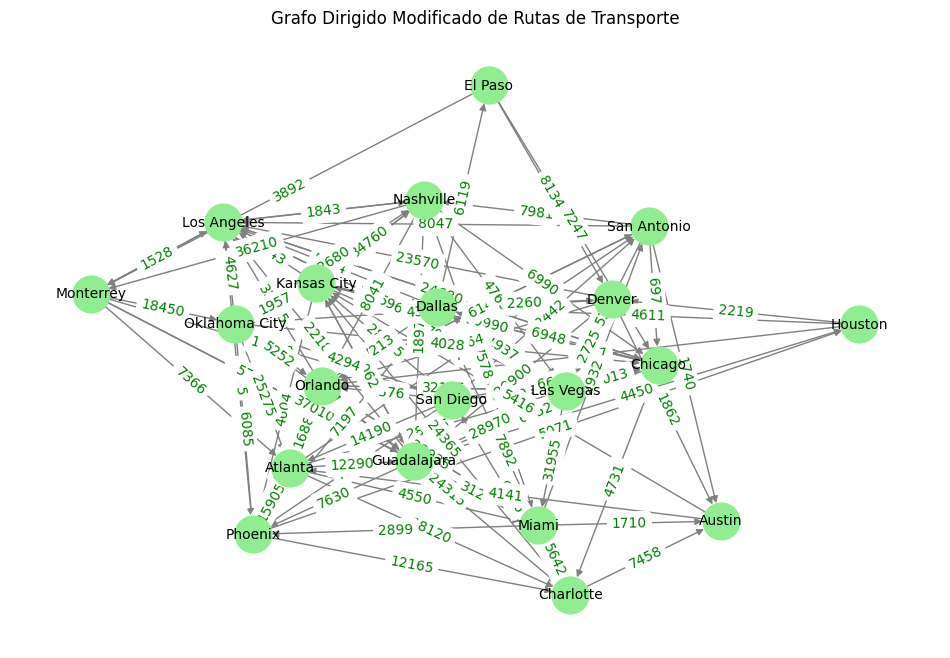

In [9]:
# Parametros

tiempo_minimo = 70  # Tiempo minimo de 70 horas

origen = "Guadalajara"  # Ciudad de origen
destino = "Miami"  # Ciudad de destino


# Hacer un nuevo grafo con los costos ajustados por la carga y tiempo minimo
def crear_grafo_dirigido_modificado_2(df_r, df_c):
    G = nx.DiGraph()  # Crear un grafo dirigido vacio

    # Diccionario ciudad -> estado
    ciudad_a_estado = {}
    for index, row in df_c.iterrows():
        ciudad_a_estado[row["Ciudad"]] = row["Estado"]

    # Agregar nodos al grafo desde el dataframe de centros logísticos
    for index, row in df_r.iterrows():
        costo_aereo = 0  # Inicializar costo aereo en 0
        costo_base = 0

        # No agregar rutas terrestres en Texas
        if (
            ciudad_a_estado[row["Destino"]] == "Texas"
            or ciudad_a_estado[row["Origen"]] == "Texas"
        ):
            if row["Aereo"] == 0:  # Si es ruta terrestre
                continue  # No agregues esta arista

        # Agregar costo especial para todas las rutas aereas
        if row["Aereo"] == 1:  # Si es ruta aerea
            costo_aereo = 500 + 3 * row["Distancia"] + 50 * row["Vuelos"]
        elif row["Aereo"] == 0:  # Si es ruta terrestre
            costo_base = (
                15 * row["Distancia"]
                + 200 * row["Frontera"]
                + (150 if row["Alta_Demanda"] == 1 else 0)
            )  # Costo base para rutas terrestres

        tiempo = (
            row["Distancia"] / row["Velocidad"]
        )  # Tiempo en horas = Distancia / Velocidad

        G.add_edge(
            row["Origen"],
            row["Destino"],
            costo=costo_base + costo_aereo,
            distancia=row["Distancia"],
            tiempo=tiempo,
            frontera=row["Frontera"],
            tipo="Aerea" if row["Aereo"] == 1 else "Terrestre",
            capacidad=row["Capacidad"],
            horario=row["Horario"],
        )  # Agregar arista con atributos
    return G


# Crear el grafo dirigido modificado

G_mod = crear_grafo_dirigido_modificado_2(df_r, df_c)

# Graficar el grafo modificado
plt.figure(figsize=(12, 8), facecolor="white")
pos = nx.spring_layout(G_mod)
nx.draw_networkx(
    G_mod,
    pos,
    with_labels=True,
    node_color="lightgreen",
    edge_color="gray",
    node_size=700,
    font_size=10,
)
# Mostrar los costos en las aristas
edge_labels = nx.get_edge_attributes(G_mod, "costo")
nx.draw_networkx_edge_labels(G_mod, pos, edge_labels=edge_labels, font_color="green")
plt.title("Grafo Dirigido Modificado de Rutas de Transporte")
plt.axis("off")
plt.show()

### 1.3.2 Encontrar la ruta más corta con Dijkstra que cumpla el tiempo minimo de 70 horas


In [10]:
import heapq  # Importar heapq para la cola de prioridad, nos permite manejar la lista de nodos a explorar de manera eficiente y con las prioridades correctas


def dijkstra_modificado(G, source, target, tiempo_minimo):

    heap = [
        (0, 0, source, [source])
    ]  # (costo acumulado, tiempo acumulado, nodo actual, ruta actual) ESTO DEFINE LA PRIORIDAD
    visitados = dict()

    while heap:
        costo_acumulado, tiempo_acumulado, nodo_actual, ruta_actual = heapq.heappop(
            heap
        )  # Extraer el nodo con el menor costo acumulado

        if nodo_actual == target:
            if (
                tiempo_acumulado >= tiempo_minimo
            ):  # Si el tiempo acumulado cumple con el tiempo minimo
                return (
                    ruta_actual,
                    costo_acumulado,
                    tiempo_acumulado,
                )  # Retornar la ruta, costo y tiempo
            continue  # Si llegamos al nodo destino y no cumple con el tiempo minimo. Seguir explorando otras rutas, esta se descarta

        clave = (
            nodo_actual,
            int(tiempo_acumulado * 60 + 0.5),
        )  # Clave unica para el nodo y el tiempo acumulado redondeado a 2 decimales
        if (
            clave in visitados and visitados[clave] <= costo_acumulado
        ):  # Si ya visitamos este nodo con un costo menor o igual
            continue  # Saltar a la siguiente iteracion
        visitados[clave] = (
            costo_acumulado  # Marcar el nodo actual como visitado con el costo acumulado
        )

        for vecino in G.neighbors(nodo_actual):  # Explorar los vecinos del nodo actual

            if vecino in ruta_actual:
                continue  # Evitar ciclos

            edge_data = G.get_edge_data(
                nodo_actual, vecino
            )  # Obtener los datos de la arista

            heapq.heappush(
                heap,
                (
                    costo_acumulado + edge_data["costo"],  # Nuevo costo acumulado
                    tiempo_acumulado + edge_data["tiempo"],  # Nuevo tiempo acumulado
                    vecino,  # Nodo vecino
                    ruta_actual + [vecino],  # Nueva ruta actual
                ),
            )

    return (
        None,
        float("inf"),
        float("inf"),
    )  # Si no se encuentra una ruta, retornar None y costos infinitos


G_mod = crear_grafo_dirigido_modificado_2(df_r, df_c)
ruta, costo_total, tiempo_total = dijkstra_modificado(
    G_mod, origen, destino, tiempo_minimo
)

if ruta:
    print(
        f"Ruta más barata desde {origen} a {destino} con al menos {tiempo_minimo} horas: {' -> '.join(ruta)}"
    )
    print(f"Costo total de la ruta: ${costo_total:.2f}")
    print(f"Tiempo total de la ruta: {tiempo_total:.2f} horas")

# * Probar ruta Guadalajara, Houston, Orlando, Atlanta, Miami, esta es que se reporta como la solucion
ruta_prueba = ["Guadalajara", "Houston", "Orlando", "Atlanta", "Miami"]
costo_prueba, distancia_prueba, tiempo_prueba = calcular_costos_ruta(G_mod, ruta_prueba)
print(f"\nRuta de prueba: {' -> '.join(ruta_prueba)}")
print(f"Costo total de la ruta de prueba: ${costo_prueba:.2f}")
print(f"Distancia total de la ruta de prueba: {distancia_prueba:.2f} km")
print(f"Tiempo total de la ruta de prueba: {tiempo_prueba:.2f} horas")

Ruta más barata desde Guadalajara a Miami con al menos 70 horas: Guadalajara -> Kansas City -> Las Vegas -> Denver -> Orlando -> Miami
Costo total de la ruta: $22911.00
Tiempo total de la ruta: 80.74 horas

Ruta de prueba: Guadalajara -> Houston -> Orlando -> Atlanta -> Miami
Costo total de la ruta de prueba: $33227.00
Distancia total de la ruta de prueba: 5961.00 km
Tiempo total de la ruta de prueba: 71.73 horas
